# Compare inference time of CapsNet vs ConvNet on MNIST

In [88]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tf.__version__
%matplotlib inline

In [89]:
# Setting PATH to import utils functions from python file to notebook

import os
import sys
directory_path = os.path.abspath(os.path.join('../src'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

from utils.load_data import load_mnist
from CapsNet import CapsNet

In [90]:
(X_train, y_train), (X_test , y_test) = load_mnist(size=(1024, 512))
X_train.shape, y_train.shape

(TensorShape([1024, 28, 28, 1]), (1024,))

## Baseline model

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [92]:
model.compile(tf.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
tf_y_train = tf.keras.utils.to_categorical(y_train)
tf_y_test = tf.keras.utils.to_categorical(y_test)

history = model.fit(X_train, tf_y_train, epochs=10, batch_size=32, validation_data=(X_test, tf_y_test))

Epoch 1/10
32/32 [==============================] - 0s 9ms/step - loss: 1.2872 - accuracy: 0.6240 - val_loss: 0.6565 - val_accuracy: 0.7930
Epoch 2/10
32/32 [==============================] - 0s 7ms/step - loss: 0.4099 - accuracy: 0.8730 - val_loss: 0.4646 - val_accuracy: 0.8672
Epoch 3/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2745 - accuracy: 0.9238 - val_loss: 0.3882 - val_accuracy: 0.8730
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2034 - accuracy: 0.9395 - val_loss: 0.3448 - val_accuracy: 0.9004
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9678 - val_loss: 0.3848 - val_accuracy: 0.8828
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1011 - accuracy: 0.9727 - val_loss: 0.3367 - val_accuracy: 0.8848
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0752 - accuracy: 0.9805 - val_loss: 0.3316 - val_accuracy: 0.9043
Epoch 8/10
32/32 [==

## CapsNet model

In [94]:
params = {
    "epochs": 10,
    "epsilon": 1e-7,
    "m_minus": 0.1,
    "m_plus": 0.9,
    "lambda_": 0.5,
    "alpha": 0.0005,
    "no_of_conv_kernels": 128,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

caps_model = CapsNet(**params)
caps_model._name = 'CapsNet-MNIST'
caps_model.compile()

In [95]:
caps_model.fit(X_train, y_train, tf.keras.optimizers.legacy.Adam(), train_metrics=['accuracy'], validation=(X_test, y_test))

Epoch 10/10: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s, Training loss : 0.0003, Validation loss : 0.0010]


{'accuracy': ListWrapper([0.779296875, 0.8935546875, 0.939453125, 0.958984375, 0.9755859375, 0.9873046875, 0.9921875, 0.9921875, 0.9951171875, 0.99609375]),
 'loss': ListWrapper([0.007964505814015865, 0.0031337446998804808, 0.0018885111203417182, 0.0012746605789288878, 0.0009122444316744804, 0.000681231846101582, 0.000524351722560823, 0.00040316718514077365, 0.0003429397474974394, 0.00027302210219204426]),
 'val_accuracy': ListWrapper([0.6640625, 0.818359375, 0.89453125, 0.916015625, 0.93359375, 0.947265625, 0.947265625, 0.955078125, 0.955078125, 0.955078125]),
 'val_loss': ListWrapper([0.0050697969272732735, 0.002881773980334401, 0.0020152225624769926, 0.0016062146751210093, 0.0013500171480700374, 0.001212105737067759, 0.00110441108699888, 0.00107385718729347, 0.0009980419417843223, 0.0009950713720172644])}

In [96]:
caps_model.training_metrics['loss'] = [loss * 100 for loss in caps_model.training_metrics['loss']]
caps_model.training_metrics['val_loss'] = [val_loss * 100 for val_loss in caps_model.training_metrics['val_loss']]

caps_model.training_metrics = {
    'loss': caps_model.training_metrics['loss'],
    'accuracy': caps_model.training_metrics['accuracy'],
    'val_loss': caps_model.training_metrics['val_loss'],
    'val_accuracy': caps_model.training_metrics['val_accuracy'],
}

## Evaluation

In [121]:
import time

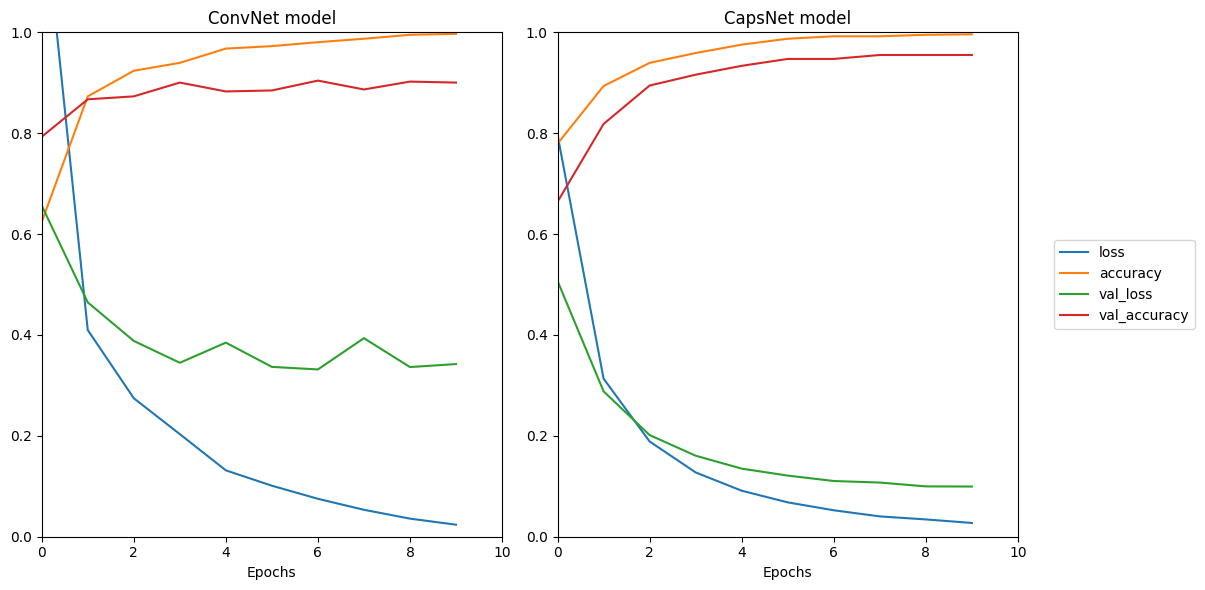

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_baseline = pd.DataFrame(history.history)
plot_baseline = df_baseline.plot(ax=axes[0], title="ConvNet model", legend=False)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, 10)

df_capsnet = pd.DataFrame(caps_model.training_metrics)
plot_capsnet = df_capsnet.plot(ax=axes[1], title="CapsNet model")  # Set legend=False here
axes[1].set_ylim(0, 1)
axes[1].set_xlim(0, 10)

axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")

# Show only one legend for both plots
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, loc='center right', bbox_to_anchor=(1.4, 0.5), fancybox=True, ncol=1)

plt.tight_layout()
plt.show()

In [130]:
n_rounds = 100

In [142]:
conv_inv_time = []
for i in range(n_rounds):
    start = time.time()
    model.predict(X_test, verbose=False)
    end = time.time()
    conv_inv_time.append((end - start) / len(X_test) * 1000)

In [143]:
caps_inv_time = []
for i in range(n_rounds):
    start = time.time()
    caps_model.predict(X_test)
    end = time.time()
    caps_inv_time.append((end - start) / len(X_test) * 1000)

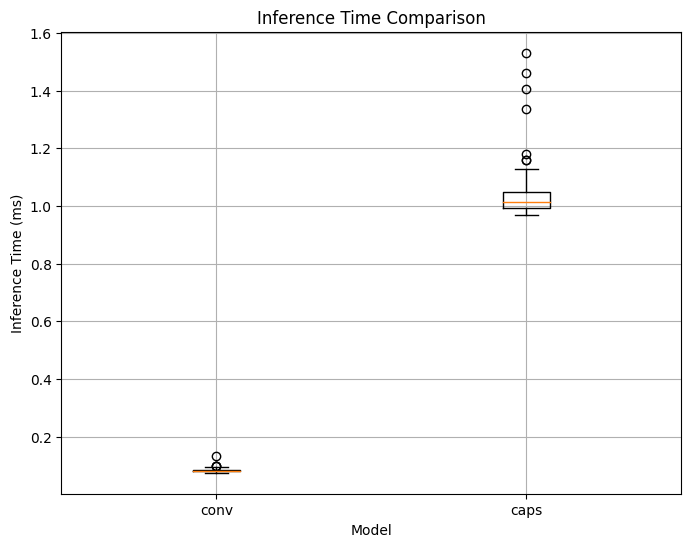

In [145]:
df = pd.DataFrame({
    "conv": conv_inv_time,
    "caps": caps_inv_time
})
plt.figure(figsize=(8, 6))
plt.boxplot(df.values, labels=df.columns)
plt.title('Inference Time Comparison')
plt.xlabel('Model')
plt.ylabel('Inference Time (ms)')
plt.grid(True)
plt.show()